# Wholesale Customer Loyalty 

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import scikitplot as skplt

import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

imports = [pd, np, sns, sklearn, ]
for pkg in imports:
    print(f'{pkg.__name__} is at version {pkg.__version__}.')

In [2]:
data_dir = '/home/amaurer/Documents/Data Challenge/data/wholesale/'
data_file = 'wholesale_data.csv'

data = pd.read_csv(data_dir + data_file)

data.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,6048141,2017,12669,9656,7561,214,2674,1338
1,2,9336325,2017,7057,9810,9568,1762,3293,1776
2,2,6272942,2017,6353,8808,7684,2405,3516,7844
3,1,7856217,2017,13265,1196,4221,6404,507,1788
4,2,6179511,2017,22615,5410,7198,3915,1777,5185


Interesting, this `Channel` column does not appear in the description.

# Check Data Integrity

Key things I've done:

  - Not sure what `Channel` is describing. I'll keep it in case it means something.
  - `Customer` is not a unique column -- some customers have entries from 2016. Maybe join these and see if 2016 spending has high correlation to 2017 spending across columns?

In [3]:
data.dtypes

Channel              int64
Customer             int64
Year                object
Fresh               object
Milk                object
Grocery             object
Frozen              object
Detergents_Paper    object
Delicassen          object
dtype: object

In [8]:
def non_ints(dataframe, cols):
    """Put in a Pandas series and get a list of non-string entries"""
    non_ints = []
    for col in cols:
        for value in dataframe[col]:
            try:
                int(value)
            except:
                non_ints.append(value)
    return set(non_ints)

obj_cols = ['Year', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

non_ints(data, obj_cols)

{'08/01/2016'}

In [9]:
data = data.replace('08/01/2016', 2016)
data = data.replace(['unrecorded', np.nan])

In [10]:
for col in obj_cols:
    data[col] = data[col].astype(int)

In [11]:
data.dtypes

Channel             int64
Customer            int64
Year                int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

Not sure what's going on with this `Channel` column

In [12]:
data.Channel.value_counts()

1    525
2    276
Name: Channel, dtype: int64

In [13]:
data.Customer.is_unique

False

In [14]:
data.Year.value_counts()

2017    440
2016    361
Name: Year, dtype: int64

In [15]:
data.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,6048141,2017,12669,9656,7561,214,2674,1338
1,2,9336325,2017,7057,9810,9568,1762,3293,1776
2,2,6272942,2017,6353,8808,7684,2405,3516,7844
3,1,7856217,2017,13265,1196,4221,6404,507,1788
4,2,6179511,2017,22615,5410,7198,3915,1777,5185


# Exploratory Data Analysis

## Repeated customer IDs
The `Customer` ID column is not unique. It looks like this is because some are listed as `2017` while others are listed as `08/01/2016`. Presumably these are customers for whom we have data from 2016.

In [17]:
data.Customer.is_unique

False

In [18]:
repeated = data[data.duplicated(subset=['Customer'], keep=False)].sort_values(by=['Customer','Year'])
repeated.shape

(644, 9)

In [20]:
repeated.head()

,Channel,Customer,Year,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
463,2,1133724,2016,16879,27681,16734,3402,3600,11566
23,2,1133724,2017,26373,36423,22019,5154,4337,4334
687,1,1134744,2016,12891,273,328,1350,28,600
247,1,1134744,2017,13569,346,489,2077,44,659
677,1,1143896,2016,15327,2073,362,2641,22,863


# Total 2017 Spending

In [73]:
year = 2017
year_data = data[data.Year == year]

year_data = data

In [74]:
depts = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

total_spent = year_data[depts].sum(axis=0)

total_spent

Fresh               8864164
Milk                4162508
Grocery             5740075
Frozen              2122548
Detergents_Paper    2166087
Delicassen          1081931
dtype: int64

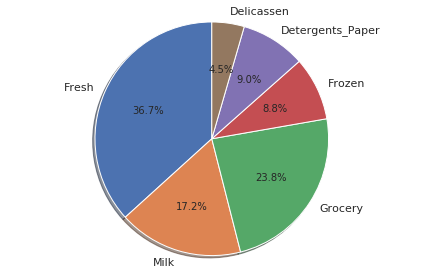

In [75]:
labels = total_spent.index
sizes= total_spent.values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

plt.tight_layout()
plt.show()

In [32]:
grand_total = '{:,}'.format(total_spent.sum()) 
print(f'2017 Revenue: ${grand_total}')

2017 Revenue: $14,579,869


## Correlations between spending in various categories

In [45]:
spending_data = data[depts]

spending_data.corr().style.background_gradient(cmap='coolwarm', axis=None)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1,0.0856979,-0.014498,0.35885,-0.10579,0.249374
Milk,0.0856979,1,0.721055,0.115429,0.673879,0.364301
Grocery,-0.014498,0.721055,1,-0.0270829,0.909032,0.196216
Frozen,0.35885,0.115429,-0.0270829,1,-0.12265,0.415317
Detergents_Paper,-0.10579,0.673879,0.909032,-0.12265,1,0.0683167
Delicassen,0.249374,0.364301,0.196216,0.415317,0.0683167,1


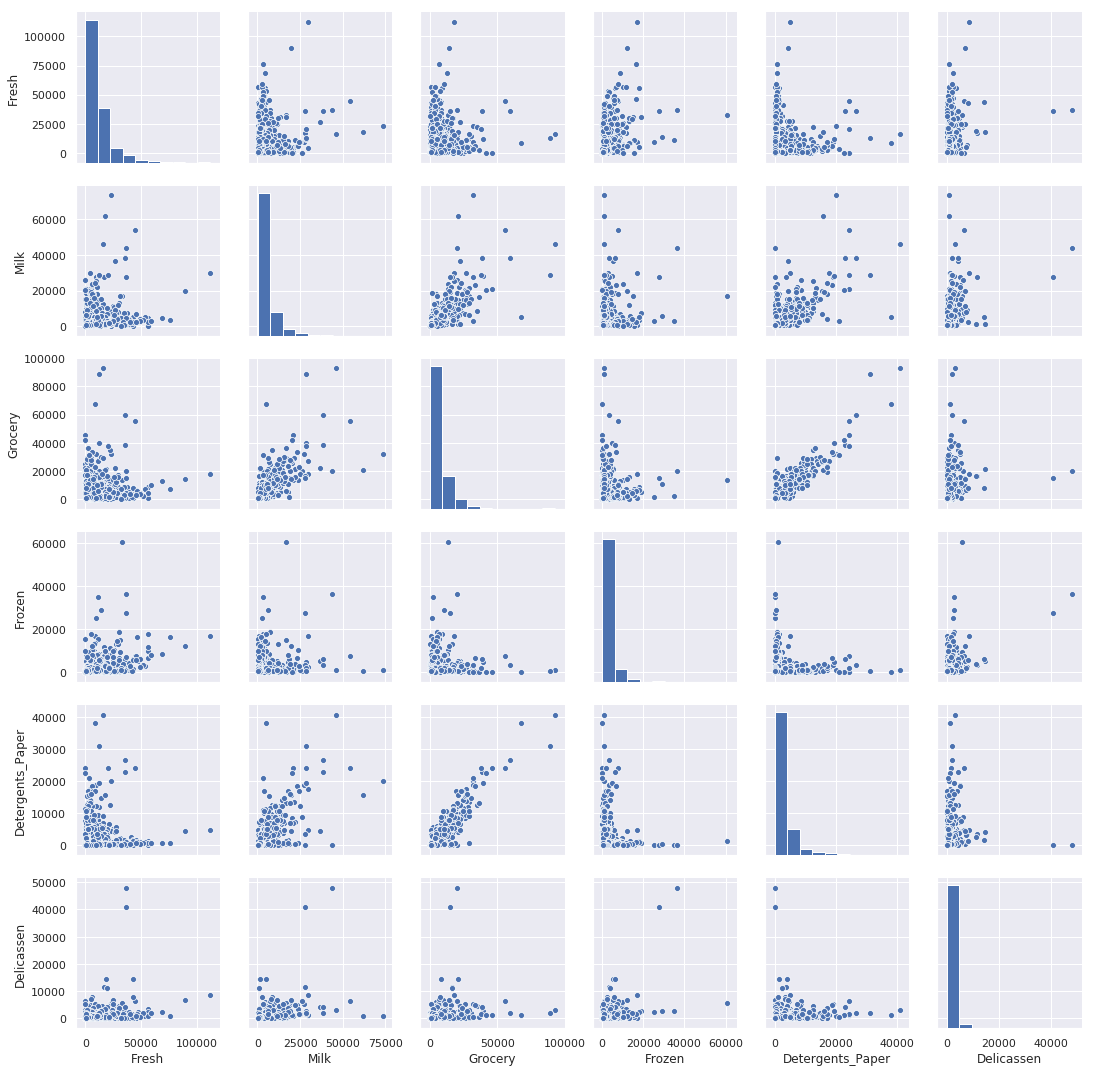

In [47]:
sns.pairplot(spending_data)

# Replace with percentages

In [65]:
spending_data = data[depts]

row_sums = spending_data.sum(axis=1)

for col in depts:
    spending_data[col] = spending_data[col] / row_sums
    
spending_data

/home/amaurer/.anaconda3/envs/insight2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.371394,0.283068,0.221652,0.006273,0.078389,0.039224
1,0.212139,0.294896,0.287621,0.052967,0.098990,0.053388
2,0.173532,0.240590,0.209888,0.065692,0.096039,0.214258
3,0.484460,0.043680,0.154158,0.233885,0.018516,0.065301
4,0.490564,0.117354,0.156139,0.084924,0.038547,0.112473
5,0.352415,0.309210,0.191913,0.024934,0.067203,0.054324
6,0.458190,0.120877,0.263556,0.018137,0.118647,0.020593
7,0.256767,0.167903,0.319341,0.056544,0.112511,0.086933
8,0.318979,0.195143,0.331229,0.022735,0.091794,0.040120
9,0.128713,0.237731,0.404633,0.024838,0.159123,0.044962


In [66]:
spending_data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.378565,0.166184,0.229547,0.100670,0.078223,0.046811
std,0.255647,0.114965,0.146190,0.111567,0.086125,0.044045
min,0.000128,0.004864,0.000078,0.000291,0.000111,0.000044
25%,0.140751,0.071766,0.103205,0.025589,0.012958,0.016416
50%,0.365423,0.141664,0.207858,0.059692,0.034828,0.036914
75%,0.596678,0.239774,0.333785,0.130871,0.132933,0.061680
max,0.953158,0.631162,0.738939,0.663223,0.533080,0.429491


In [64]:
(spending_data == 0).sum(axis=0)

Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Text(0.5, 1.0, 'Spending Proportion by Department')

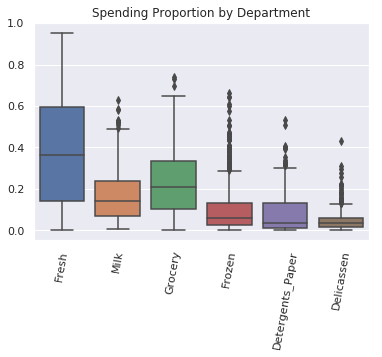

In [72]:
sns.boxplot(data=spending_data)
plt.xticks(rotation=80)
plt.title('Spending Proportion by Department')

In [79]:
print('Fraction buying over half their groceries in this category:')
for col in depts:
    frac = np.sum(spending_data[col] > 0.5) / spending_data.shape[0]
    print(f'{col}: {round(frac,4)}')

Fraction buying over half their groceries in this category:
Fresh: 0.3583
Milk: 0.0125
Grocery: 0.0462
Frozen: 0.0112
Detergents_Paper: 0.0025
Delicassen: 0.0
